In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d antobenedetti/animals

 98% 867M/882M [00:07<00:00, 143MB/s]
100% 882M/882M [00:07<00:00, 126MB/s]


In [4]:
import zipfile

zip_ref= zipfile.ZipFile('/content/animals.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()



In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras import layers, models
import os
import cv2
from sklearn.utils import shuffle

In [6]:
#generators
train_ds= keras.utils.image_dataset_from_directory(
    directory='/content/animals/train',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32, image_size=(256, 256)

)

validation_ds= keras.utils.image_dataset_from_directory(
    directory='/content/animals/val',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32, image_size=(256, 256)
)

Found 13474 files belonging to 5 classes.
Found 1497 files belonging to 5 classes.


In [19]:
# gives the list of all directories and subdirectories
train = list(os.walk('/content/animals/train'))

In [8]:
train[0][1]

['elephant', 'cat', 'dog', 'horse', 'lion']

In [20]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'elephant': 0, 'cat': 1, 'dog': 2, 'horse': 3, 'lion': 4}


In [26]:
from tqdm import tqdm


In [13]:
def dataset(path): # put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):

# dict_labels is the dictionary whose key:value pairs are classes:numbers
# representing them
        value_of_label = dict_labels[folder]
    return value_of_label
value_of_label  = dataset('/content/animals/train')

100%|██████████| 5/5 [00:00<00:00, 43509.38it/s]


In [14]:
value_of_label

4

In [25]:
def dataset(path): # put path till the highest directory level
    images = []
    labels = []

    for folder in tqdm(os.listdir(path)):

# dict_labels is the dictionary whose key:value pairs are classes:numbers
# representing them
        value_of_label = dict_labels[folder]
        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

    return path_of_file
path_of_file  = dataset('/content/animals/train')

100%|██████████| 5/5 [00:00<00:00, 83.15it/s]


In [22]:
path_of_file

'/content/animals/train/lion/lion499.jpg'

In [ ]:
def dataset(path): # put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):

# dict_labels is the dictionary whose key:value pairs are classes:numbers
# representing them
        value_of_label = dict_labels[folder]

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('/content/animals/train')
images, labels = shuffle(images, labels)

In [31]:
images.shape

(13474, 150, 150, 3)

In [29]:
labels.shape

(13474,)

## **Number of images of each species**

In [49]:
train[0][1]

['elephant', 'cat', 'dog', 'horse', 'lion']

In [43]:
len(train[2][0])

26

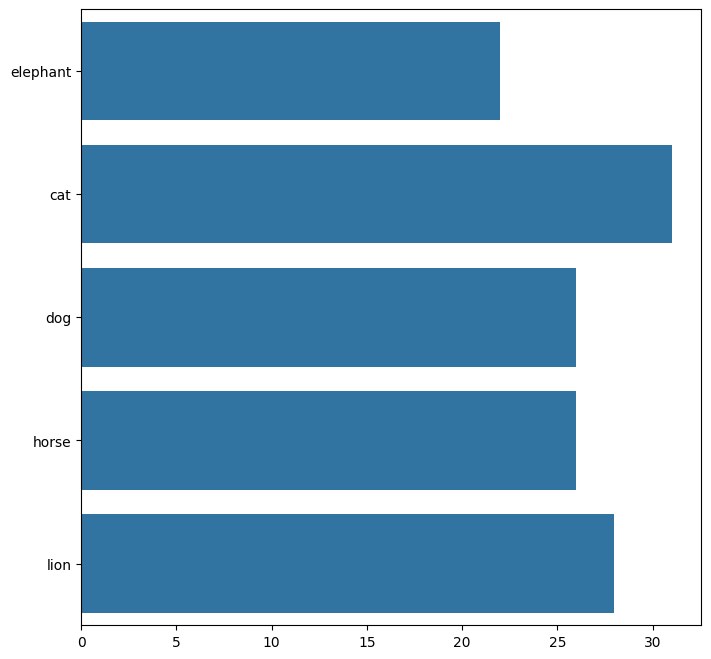

In [41]:
import seaborn as sns
animals = train[0][1]
no_of_animals = []
for i in range(0, 5):
    no_of_animals.append(len(train[i][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y = animals, x = no_of_animals);

### **Sample Image**

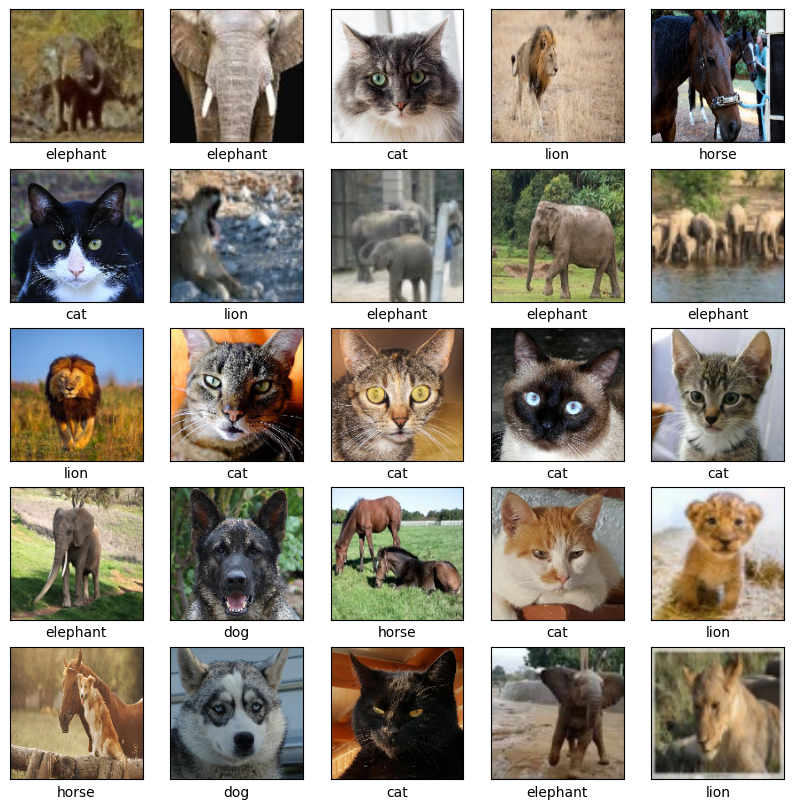

In [50]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

# **Load images using ImageDatagenerator**

The purpose of using an ImageDatagenerator in a machine learning context is to perform real-time data augmentation, normalization, and batching of images during training. Here's an explanation:

Data Augmentation:

ImageDatagenerator is often used to perform data augmentation, which involves applying random transformations to the training images.
Common augmentations include rotation, zooming, horizontal and vertical flipping, and shearing.
Augmentation helps the model become more robust by exposing it to a wider variety of variations in the training data.
Normalization:

The generator can normalize the pixel values of the images. Normalization typically involves scaling the pixel values to a range between 0 and 1 or centering them with a mean and standard deviation.
Normalization helps the model converge faster during training.
Batching:

Instead of loading all images into memory at once, an ImageDatagenerator allows you to load and process images in batches.
Batching is essential for training deep learning models, especially when dealing with large datasets that may not fit into memory.

In [ ]:
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for the training data
train_generator = train_datagen.flow_from_directory(
    '/content/animals/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Accessing an augmented batch of images
augmented_batch = next(train_generator)

'''

In this example, train_datagen is an ImageDataGenerator configured with various augmentation options, and train_generator is created using flow_from_directory. The next(train_generator) call retrieves a batch of augmented images and their corresponding labels.

In [53]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 4 # Number of samples that will be processed in each iteration during training.

train_datagen = ImageDataGenerator(
    rescale = 1./255,  # Normalizes pixel values to the range of 0 to 1.
#     shear_range = 0.1, # Randomly applies shearing transformations to images.
#     zoom_range = 0.1,  # Randomly zooms in or out of images.
#     horizontal_flip = True,  # Randomly flips images horizontally.
#     width_shift_range = 0.1, # Randomly shifts images horizontally.
#     height_shift_range = 0.1 # Randomly shifts images vertically.
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/animals/train',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/animals/val',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 13474 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.


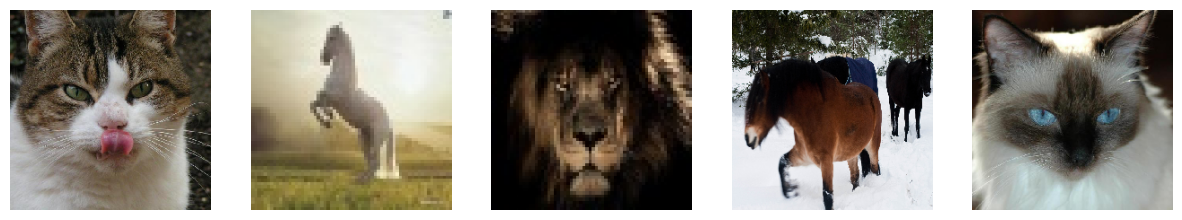

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_generator)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# **Explanation**:

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15)):

plt.subplots creates a figure and a set of subplots. Here, you are creating a single row with 5 subplots (ncols=5).
fig is the entire figure, and ax is an array of Axes objects representing each subplot.
for i in range(5)::

This loop iterates 5 times, creating one subplot for each iteration.
image = next(train_generator)[0][0]:

train_generator is likely an iterator, and you are using next to get the next batch of data. [0][0] extracts the first image from the batch.
The assumption here is that each batch from the generator contains both images and labels, and you are interested in the images.
image = np.squeeze(image):

np.squeeze removes single-dimensional entries from the shape of an array. It's used here to remove any singleton dimensions, ensuring image is a 2D array (if it was 3D with a singleton dimension).
ax[i].imshow(image):

ax[i] refers to the ith subplot, and imshow is used to display the image in that subplot.
ax[i].axis(False):

This turns off the axis labels and ticks for the current subplot.
In summary, this code generates a row of 5 subplots, each showing an image from the training generator. It's a quick way to visualize a few examples from the training set. If train_generator is a generator that yields batches of images and labels, make sure it's properly configured for your task and has been set up with the necessary preprocessing and augmentation.

# **VGG-16 (Transfer Learning)**

In [56]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [57]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False, # Not including the Dense Layer
    input_shape = (224,224,3)
)

58889256/58889256 [==============================] - 0s 0us/step


# **Setting conv_base.trainable = False has the following effects:**
**1. Freezing Weights:**

It prevents the weights of the convolutional layers within conv_base from being updated during the training process. This means that the learned feature representations from ImageNet will remain unchanged.

**2. Faster Training:**

By freezing the majority of the model's weights, you significantly reduce the number of parameters that need to be adjusted during training. This leads to faster training times and less computational resources required.

**3. Transfer Learning:**

This technique is often used in transfer learning, where you leverage the knowledge of a pre-trained model on a different task. By freezing the base layers, you preserve the generic feature extraction capabilities and focus on fine-tuning the new layers you add on top for your specific task.

In [58]:
conv_base.trainable = False

In [59]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(120,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               30840     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                3

In [60]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [61]:
history = model.fit(train_generator,epochs=20,validation_data=test_generator)

Epoch 1/20
  11/3369 [..............................] - ETA: 1:52:22 - loss: 2.2559 - accuracy: 0.1591

KeyboardInterrupt: 

In [ ]:
#Normalize
def process(image, label):
  image= tf.cast(image/255., tf.float32)
  return image, label

train_ds= train_ds.map(process)
validation_ds= validation_ds.map(process)

In [ ]:
# Accessing labels in train_ds
#for images, labels in train_ds:
#    print(labels)

In [ ]:
validation_ds.class_names

In [ ]:
# create CNN model
#3 cov layer 32, 64, 128 filters
model= Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3) ))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides= 2))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3) ))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides= 2))

model.add(Conv2D(256, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3) ))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides= 2))

model.add(Flatten())

model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))


In [ ]:
model.summary()

In [ ]:
# model compilation and execution

model.compile(optimizer='Adam', loss= 'binary_crossentropy', metrics= 'Accuracy')

In [ ]:
history= model.fit(train_ds, epochs= 555, validation_data= validation_ds)

In [ ]:
from keras.layers import BatchNormalization, Dropout